In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

# WirVsVirus Hackathon

Die entscheidende Frage bei der Beurteilung aller Maßnahmen ist, ob das exponentielle Wachstum verlangsamt worden ist, d.h. die exponentielle Wachstumskurve abflacht.
Dazu macht man am besten anhand bestehender Daten ein Modell-Fit und schaut, ob aktuelle Fallzahlen das Modell überschreiten oder man mit den Fallzahlen darunter bleibt.

## Download Data from CSSE COVID-19 Dataset

We are using the Covid-19 Dataset: https://github.com/CSSEGISandData/COVID-19

In [2]:
url = 'https://raw.githubusercontent.com'
url += '/CSSEGISandData/COVID-19'
url += '/master/csse_covid_19_data/csse_covid_19_time_series'
url += '/time_series_19-covid-Confirmed.csv'
print('Downloading from %s' % url)

In [3]:
confirmed = pd.read_csv(url)

In [4]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


### Preprocessing

In [5]:
ger_confirmed = confirmed[confirmed['Country/Region']=='Germany'].T
ger_confirmed = ger_confirmed[4:].astype('int')
ger_confirmed.columns = ['confirmed']

In [6]:
ger_confirmed.index = pd.to_datetime(ger_confirmed.index)
ger_confirmed = ger_confirmed.asfreq('D')

Filter der Daten: Wir nehmen für die Modellbildung erst den Tag als Beginn, an dem der 100. Erkrankte gemeldet wurde.

In [7]:
ger_confirmed = ger_confirmed[ger_confirmed.confirmed>=100]

In [8]:
today = ger_confirmed.index[-1]

## Feature

In [9]:
ger_confirmed['days'] = (ger_confirmed.index - ger_confirmed.index.min()).days

In [10]:
ger_confirmed.head()

,confirmed,days
2020-03-01,130,0
2020-03-02,159,1
2020-03-03,196,2
2020-03-04,262,3
2020-03-05,482,4


## Ausgangssperren

Am Wochenende 20.03./21.03.2020 haben einige Gemeinden und Städte Ausgangssperren verhängt (z.B. [Dresden](https://www.dresden.de/media/pdf/presseamt/Allgemeinverfuegung.pdf), Mitterteich, ganz Bayern usw). Daher werden wir uns das Datum mal merken.

In [11]:
import time
import datetime

In [12]:
ausgangssperren_timestamp = datetime.date(2020, 3, 21)

In [13]:
ausgangssperren_timestamp_epoch = time.mktime(ausgangssperren_timestamp.timetuple())*1000

## Prediction Model

Ein exponentielles Wachstum (freie Ansteckung) verläuft nach:

$y = A e^{Bx}$

Wenn wir das logarithmieren mit dem Log zur Basis $e$, haben wir ein lineares Modell.

$\log_e(y) = B x + \log_e (A)$

In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [15]:
X = ger_confirmed['days'].values.reshape(-1, 1)
y = ger_confirmed['confirmed'].values
logy = np.log(y)

### Train

In [16]:
clf = LinearRegression()
clf.fit(X, logy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
logy_pred = clf.predict(X)

Die mit dem linearen Modell vorhergesagten Werte sind im logarithmischen, müssen mit der $e^y$ noch zurück konvertiert werden.

In [18]:
ger_confirmed['predicted'] = np.exp(logy_pred).astype('int')

In [19]:
ger_confirmed.tail()

,confirmed,days,predicted
2020-03-16,7272,15,7329
2020-03-17,9257,16,9546
2020-03-18,12327,17,12434
2020-03-19,15320,18,16194
2020-03-20,19848,19,21093


### Modelparameter

In [20]:
B = clf.coef_[0]
A = np.exp(clf.intercept_)
print('Modellparameter sind A=%.1f, B=%.3f' % (A, B))

Modellparameter sind A=139.2, B=0.264


## Save the model for later use

In [21]:
import pickle

with open('%s-Germany-Covid19-Prediction-Model.pkl' % today.strftime('%Y-%m-%d'), 'wb') as f:
    pickle.dump(clf, f)
    
print('Saved the Model')

Saved the Model


## Future

In [22]:
fd = 13 # days into the future

In [23]:
# Create DataFrame in the Future
dates = pd.date_range(ger_confirmed.index[-1], periods=fd, closed='right')
days_in_future = ger_confirmed.days[-1] + np.arange(1, fd)

future = pd.DataFrame(data=days_in_future, index=dates, columns=['days'])

In [24]:
ger_future = ger_confirmed.append(future, sort=True)

### Predict the Future

In [25]:
X_future = ger_future['days'].values.reshape(-1, 1)

In [26]:
logy_pred = clf.predict(X_future)
ger_future['predicted'] = np.exp(logy_pred).astype('int')

In [27]:
ger_future

,confirmed,days,predicted
2020-03-01,130.0,0,139
2020-03-02,159.0,1,181
2020-03-03,196.0,2,236
2020-03-04,262.0,3,307
2020-03-05,482.0,4,400
2020-03-06,670.0,5,521
2020-03-07,799.0,6,679
2020-03-08,1040.0,7,885
2020-03-09,1176.0,8,1152
2020-03-10,1457.0,9,1501


## Future Plot

In [28]:
title = 'Bestätigte Fälle und Vorhersage für Deutschland (Basierend auf CSSE COVID-19 Dataset)'

Saved the Figure


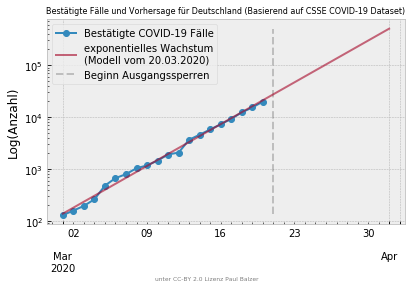

In [29]:
ax = ger_future['confirmed'].plot(label='Bestätigte COVID-19 Fälle', marker='o')
ax = ger_future['predicted'].plot(label='exponentielles Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'),
                                  alpha=0.6, ax=ax)

ax.vlines(ausgangssperren_timestamp,
          ymin=ger_future.predicted.min(),
          ymax=ger_future.predicted.max(),
          linestyle='--', alpha=0.2, label='Beginn Ausgangssperren')

ax.legend()
ax.set_ylabel('Log(Anzahl)')
ax.set_yscale('log')
ax.set_title(title, fontsize=8)
ax.annotate('unter CC-BY 2.0 Lizenz Paul Balzer', xy=(.5, 0.02), xycoords='figure fraction', ha='center', fontsize=6, color='gray')

plt.tight_layout()
plt.savefig('./%s-Germany-Covid19-Prediction.png' % today.strftime('%Y-%m-%d'), dpi=150)
print('Saved the Figure')

## Export as Excel

In [30]:
ger_future.to_excel('./%s-Germany-Covid19-Prediction.xlsx' % today.strftime('%Y-%m-%d'))
print('Saved the Excel')

Saved the Excel


# Interactive Website

We are using Bokeh to export an interactive website

In [31]:
from bokeh.plotting import figure
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import Div, HoverTool, BoxAnnotation, Span
from bokeh.layouts import column
from bokeh.io import output_file, save

In [32]:
p = figure(tools="hover,save,pan,box_zoom,reset,wheel_zoom",
           x_axis_type="datetime", y_axis_type="log",
           title=title)

# Vorhersagemodell als Linie
p.line(ger_future.index, ger_future.predicted, line_width=5, line_color='darkred',
       legend='exponentielles Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'))

# Tatsächliche Fälle als Punkte
p.circle(ger_confirmed.index, ger_confirmed.confirmed,
         fill_color="lightblue", size=12, legend='Bestätigte COVID-19 Fälle')

# X-Achse ordentlich formatieren
p.xaxis.formatter=DatetimeTickFormatter(
    years="%d.%m.%Y",
    months="%d.%m.%Y",
    days="%A %d.%m.%Y",
)

# Daten-Zeitraum
gray_box = BoxAnnotation(left=ger_confirmed.index[0],
                          right=ger_confirmed.index[-1],
                          fill_color='gray', fill_alpha=0.1)
p.add_layout(gray_box)

# Tooltips
p.select_one(HoverTool).tooltips = [
    ('Datum', '@x{%d.%m.%Y}'),
    ('Fälle', '@y{0.0a}'),
]
p.select_one(HoverTool).formatters = {'x':'datetime'}
p.select_one(HoverTool).mode = 'vline'

# Vertical line for Ausgangssperren
vline = Span(location=ausgangssperren_timestamp_epoch,
             dimension='height', line_color='gray',
             line_dash='dashed', line_width=3, name='Beginn Ausgangssperren')
p.add_layout(vline)

p.toolbar.autohide = True

# Legende
p.legend.location = "top_left"

# Anmerkung
div = Div(text="""Quellcode: <a href="https://github.com/balzer82/covid-germany-predictor">Covid Germany Predictor</a>
            unter CC-BY2.0 Lizenz von Paul Balzer on Github.
            Disclaimer: Ich bin kein Epidemiologe oder Virologe, also kein Experte!""")

# Save
output_file("./html/index.html", title='COVID-19 Prediction Germany')

save(column(p, div, sizing_mode="stretch_both"))
print('Saved the html')

Saved the html


CC-BY 2.0 Paul Balzer